# CEM gas usage

## Data

The data is located in our sharepoint site: https://cambridgeccc.sharepoint.com/sites/cem

Just browse to Documents -> records -> Utilities.xlsx

It includes all the actual readings, and estimates used in the bills.

The data is shown below.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.dates as dates
import seaborn as sns
sns.set()

table = '''
Date	Actual	Estimate	Bill	Bill units
2018-06-13	8585			 
2018-06-26	8589		£20.08	4
2018-09-03		8607	£44.65	18
2018-12-03		8743	£217.05	136
2019-03-04		9007	£395.16	264
2019-03-19	93			
2019-04-29	228		£2,073.69	1221
2019-05-10	288			'''

# data
table_lines = [line.split('\t') for line in table.splitlines()[1:]]
df = pd.DataFrame({
    'date': [line[0] for line in table_lines[1:]],
    'actual': [line[1] for line in table_lines[1:]],
    'estimate': [line[2] for line in table_lines[1:]],
    'bill': [line[3] for line in table_lines[1:]]
})
df = df[['date', 'actual', 'estimate', 'bill']]
df

,date,actual,estimate,bill
0,2018-06-13,8585,,
1,2018-06-26,8589,,£20.08
2,2018-09-03,,8607,£44.65
3,2018-12-03,,8743,£217.05
4,2019-03-04,,9007,£395.16
5,2019-03-19,93,,
6,2019-04-29,228,,"£2,073.69"
7,2019-05-10,288,,


## Processed data

The data is processed and three new columns are created to facilitate analysis:

1. **adjusted_actual**: The gas meter has only 4 digits. It goes from 9999 to 0. So I've adjusted those readings that have rolled over accordingly (by adding 10000).
2. **bill_reading**: Adjusted actual readings merged into estimates so we have all the "readings" used in the bills.
3. **days**: The number of days since "day 1", the day of the first reading.
    
The processed data is shown below.

In [3]:
# processed data
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df['actual'] = pd.to_numeric(df.actual, downcast='unsigned')
df['estimate'] = pd.to_numeric(df.estimate, downcast='unsigned')
df['bill'].replace('', np.nan, inplace=True)
# To make sense of rolled-over readings 
df['adjusted_actual'] = df.actual
df.loc[df.date > pd.Timestamp('2019-03-05'), 'adjusted_actual'] = df.actual + 10000
# Merge (adjusted) actual readings into estimates to get all "readings" used in the bills
df['bill_reading'] = df.estimate.combine_first(df.adjusted_actual)
# Number of days since "day 1".
df['days'] = (df['date'] - df['date'][0]).dt.days
df

C:\Users\snc21\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,date,actual,estimate,bill,adjusted_actual,bill_reading,days
0,2018-06-13,8585.0,NaN,NaN,8585.0,8585.0,0
1,2018-06-26,8589.0,NaN,£20.08,8589.0,8589.0,13
2,2018-09-03,NaN,8607.0,£44.65,NaN,8607.0,82
3,2018-12-03,NaN,8743.0,£217.05,NaN,8743.0,173
4,2019-03-04,NaN,9007.0,£395.16,NaN,9007.0,264
5,2019-03-19,93.0,NaN,NaN,10093.0,10093.0,279
6,2019-04-29,228.0,NaN,"£2,073.69",10228.0,10228.0,320
7,2019-05-10,288.0,NaN,NaN,10288.0,10288.0,331


## Usage Plot

As you can see in the plot below, for three quarters we did not provide any actual readings and the bills were calculated based on estimates which appear significantly lower than the actual usage.

The last bill of 2000 pounds is a "catch-up" to the actual usage.

As it stands in total it comes up to roughly 2700 pounds for the a period of 11 months.

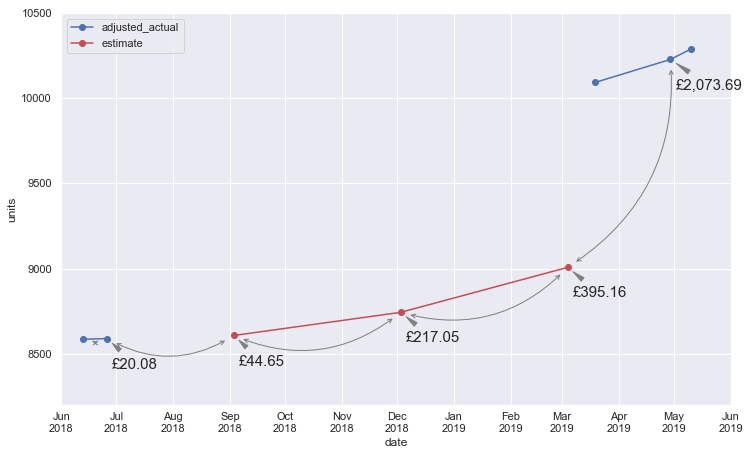

In [23]:
# plot
ax = df.plot(x='date', y=['adjusted_actual', 'estimate'], style=['bo-', 'ro-'], figsize=(12,8))
_ = ax.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-01')])
_ = ax.set_ylim([8200, 10500])
ax.set_ylabel('units')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b\n%Y'))
ax.xaxis.set_tick_params(which='major', labelbottom=False)
last_bp = (df.date[0], df.bill_reading[0])
for i, r in df.dropna(subset=['bill']).iterrows():
    ax.annotate('', (r.date, r.bill_reading), xytext = last_bp, 
        arrowprops = {'arrowstyle':'<->', 'connectionstyle':'arc3,rad=0.3', 'shrinkA':10, 'shrinkB':10, 'color':'grey'}
        )
    ax.annotate(r.bill, (r.date, r.bill_reading), xytext = (5,-30), textcoords='offset points', fontsize=15,
        arrowprops = {'arrowstyle':'wedge', 'shrinkA':7, 'shrinkB':7, 'color':'grey'})
    last_bp = (r.date, r.bill_reading)

## Simple linear regression
As you can see in the plot below, the estimate usage rate is roughly 3.5 times lower than the actual usage rate.

TypeError: must be real number, not Timestamp

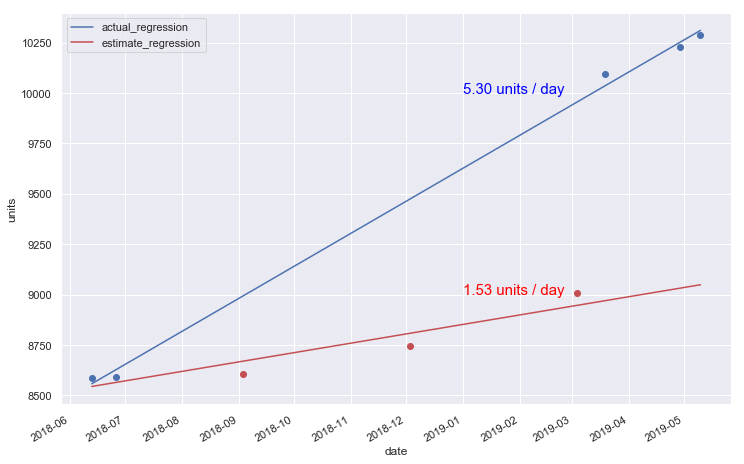

In [25]:
# simple linear regression
## actual readings - remove dates where there's no actual readings
actual_x = df[~df.adjusted_actual.isin([np.nan])].days.values
actual_y = df.adjusted_actual.dropna().values
actual_rate, actual_start = np.polyfit(actual_x, actual_y, 1)
## British Gas estimates - remove last three actual readings
estimate_x = df.days.values[:-3]
estimate_y = df.bill_reading.values[:-3]
estimate_rate, estimate_start = np.polyfit(estimate_x, estimate_y, 1)
## Regression data
regression_df = pd.DataFrame({
    'date': [df['date'].iloc[0], df['date'].iloc[-1]],
    'actual_regression': [actual_start, actual_rate * df['days'].iloc[-1] + actual_start],
    'estimate_regression': [estimate_start, estimate_rate * df['days'].iloc[-1] + estimate_start]
})
## plot graph with regression lines
ax2 = df.plot(x='date', y=['adjusted_actual', 'estimate'], style=['bo', 'ro'], figsize=(12,8), legend=False)
ax2.set_ylabel('units')
regression_df.plot(ax=ax2, x='date', style=['b', 'r'])
#actual_df.plot(ax=ax2, x='date', color='lightblue')
ax2.annotate('{:.2f} units / day'.format(actual_rate), (pd.Timestamp('2019-01-01'), 10000), color='blue', fontsize=15)
#estimate_df.plot(ax=ax2, x='date', color='pink')
ax2.annotate('{:.2f} units / day'.format(estimate_rate), (pd.Timestamp('2019-01-01'), 9000), color='red', fontsize=15)

## Conclusion
We were told at the time of purchase that 2900 pounds were spent on gas in the last full year by the previous owner. Our actual figures are not far from this. The single 2000-pound bill is to catch up the actual usage. 

In the future we should provide regular actual readings so that the bill will reflect the cost of actual usage.